In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [2]:
spy = pd.read_csv('spy_full.csv')
spy_week = pd.read_csv('spy_week.csv')
spy_month = pd.read_csv('spy_month.csv')

In [3]:
spy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8022 entries, 0 to 8021
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8022 non-null   object 
 1   close_price    8022 non-null   float64
 2   simple_return  8021 non-null   float64
 3   log_return     8021 non-null   float64
dtypes: float64(3), object(1)
memory usage: 250.8+ KB


In [4]:
spy['date'] = pd.to_datetime(spy['date'])
spy['days_elapsed'] = (spy['date'] - spy['date'].iloc[0]).dt.days
spy['log_return'] = spy['log_return'].fillna(0)

In [5]:
spy.head()

,date,close_price,simple_return,log_return,days_elapsed
0,1993-01-29,24.61,NaN,0.000000,0
1,1993-02-01,24.78,0.007112,0.007087,3
2,1993-02-02,24.84,0.002119,0.002117,4
3,1993-02-03,25.10,0.010571,0.010516,5
4,1993-02-04,25.20,0.004184,0.004175,6


In [6]:
# Create feature and targets

X = spy[['days_elapsed', 'log_return']]  
y = spy['log_return']

In [7]:
test_size = int(len(X) * 0.2)  # Train Test Split 
train_X, test_X = X.iloc[:-test_size], X.iloc[-test_size:]
train_y, test_y = y.iloc[:-test_size], y.iloc[-test_size:]

# Expanding Window CV on the Training Set
n_splits = 5
split_size = len(train_X) // (n_splits + 1)  # Split training set into folds
train_mse_scores = []
val_mse_scores = []

for i in range(1, n_splits + 1):
    # Define the expanding window
    train_end = split_size * i
    test_start = train_end
    test_end = test_start + split_size

    # Split training set into expanding train and validation sets
    cv_train_X, cv_val_X = train_X.iloc[:train_end], train_X.iloc[test_start:test_end]
    cv_train_y, cv_val_y = train_y.iloc[:train_end], train_y.iloc[test_start:test_end]

    # Train the model on the current training fold
    model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, tree_method='hist', device='cuda')
    model.fit(cv_train_X, cv_train_y)

    # Predictions for training and validation sets
    train_predictions = model.predict(cv_train_X)
    val_predictions = model.predict(cv_val_X)

    # Calculate MSE for training and validation sets
    train_mse_fold = mean_squared_error(cv_train_y, train_predictions)
    val_mse_fold = mean_squared_error(cv_val_y, val_predictions)

    # Store the scores
    train_mse_scores.append(train_mse_fold)
    val_mse_scores.append(val_mse_fold)

    # Print results for the current fold
    print(f"Fold {i}:")
    print(f"Train size: {len(cv_train_X)}, Validation size: {len(cv_val_X)}")
    print(f"Training MSE: {train_mse_fold:.10f}, Validation MSE: {val_mse_fold:.10f}\n")

C:\Users\Administrator\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:34:57] WARNING: D:\bld\xgboost-split_1732150487547\work\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Fold 1:
Train size: 1069, Validation size: 1069
Training MSE: 0.0000000261, Validation MSE: 0.0000144622

Fold 2:
Train size: 2138, Validation size: 1069
Training MSE: 0.0000000725, Validation MSE: 0.0000007518

Fold 3:
Train size: 3207, Validation size: 1069
Training MSE: 0.0000001947, Validation MSE: 0.0000243000

Fold 4:
Train size: 4276, Validation size: 1069
Training MSE: 0.0000012019, Validation MSE: 0.0000003239

Fold 5:
Train size: 5345, Validation size: 1069
Training MSE: 0.0000011003, Validation MSE: 0.0000000432



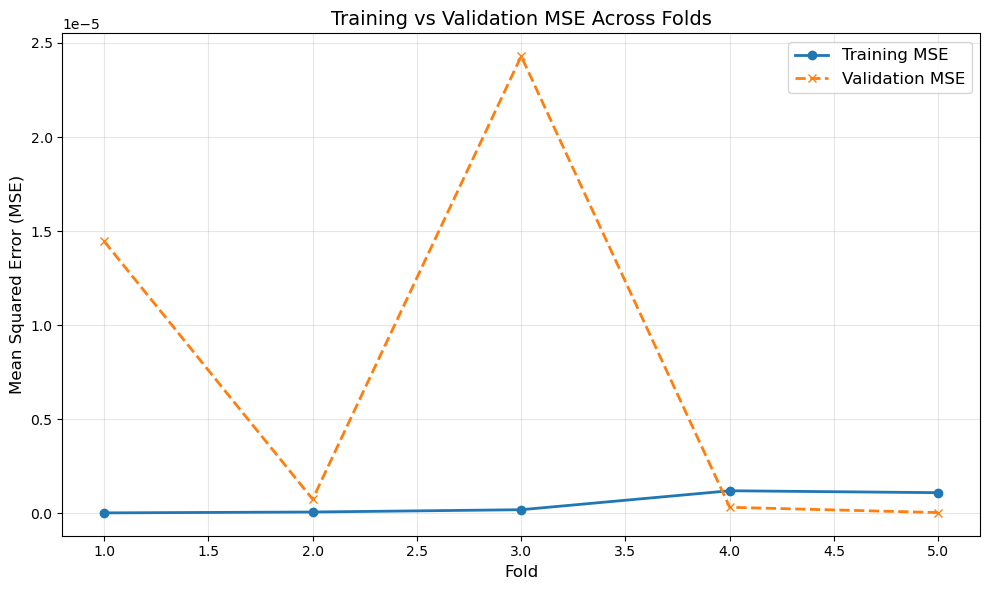

In [8]:
plt.figure(figsize=(10, 6))

plt.plot(
    range(1, len(train_mse_scores) + 1), 
    train_mse_scores, 
    label='Training MSE', 
    marker='o', 
    linestyle='-', 
    linewidth=2
)

plt.plot(
    range(1, len(val_mse_scores) + 1), 
    val_mse_scores, 
    label='Validation MSE', 
    marker='x', 
    linestyle='--', 
    linewidth=2
)

plt.title('Training vs Validation MSE Across Folds', fontsize=14)
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [9]:
final_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, tree_method='hist', device='cuda')
final_model.fit(train_X, train_y)
test_predictions = final_model.predict(test_X)
test_mse = mean_squared_error(test_y, test_predictions)

print("Final Test Set Evaluation:")
print(f"Test MSE: {test_mse:.10f}")

Final Test Set Evaluation:
Test MSE: 0.0000068874


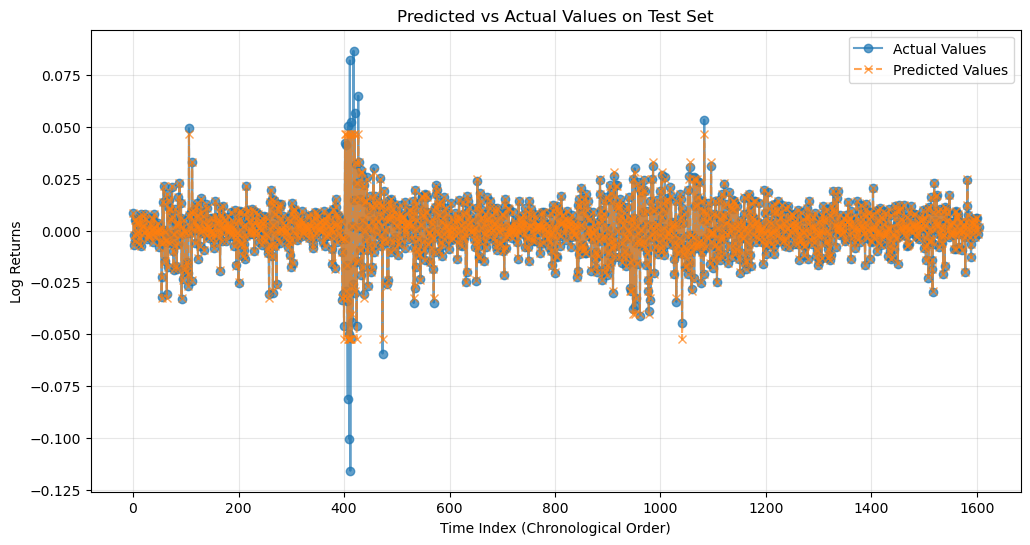

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(test_y.values, label="Actual Values", linestyle='-', marker='o', alpha=0.7)
plt.plot(test_predictions, label="Predicted Values", linestyle='--', marker='x', alpha=0.7)
plt.title("Predicted vs Actual Values on Test Set")
plt.xlabel("Time Index (Chronological Order)")
plt.ylabel("Log Returns")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

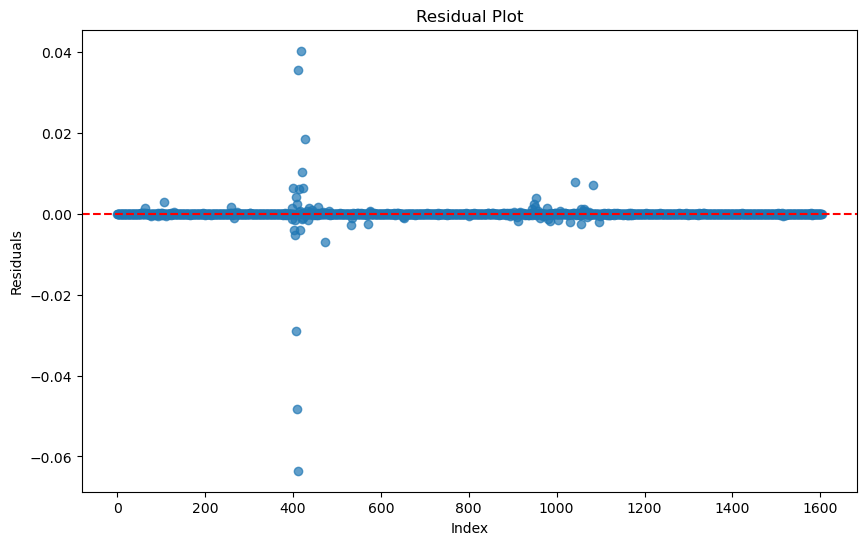

In [11]:
residuals = test_y - test_predictions
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals)), residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.show()

In [12]:
print(y.describe())
print("Variance of log_return:", y.var())

count    8022.000000
mean        0.000400
std         0.011733
min        -0.115887
25%        -0.004376
50%         0.000678
75%         0.005930
max         0.135577
Name: log_return, dtype: float64
Variance of log_return: 0.00013765549949758162


In [33]:
future_days = 365  # 1 year of daily predictions
last_day = spy['days_elapsed'].iloc[-1]  # Last days_elapsed
last_price = spy['close_price'].iloc[-1]  # Last close price
last_log_return = spy['log_return'].iloc[-1]  # Last observed log return

future_days_elapsed = [last_day]
future_log_returns = [last_log_return]
predicted_prices = [last_price]

# Recursive prediction for the next 365 days
for day in range(1, future_days + 1):
    current_input = pd.DataFrame({
        "days_elapsed": [future_days_elapsed[-1]],
        "log_return": [future_log_returns[-1]]
    })
    predicted_log_return = final_model.predict(current_input)[0]
    
    next_price = predicted_prices[-1] * np.exp(predicted_log_return)
    
    predicted_prices.append(next_price)
    future_days_elapsed.append(future_days_elapsed[-1] + 1)
    future_log_returns.append(predicted_log_return)

future_predictions = pd.DataFrame({
    "days_elapsed": future_days_elapsed,
    "predicted_log_return": future_log_returns,
    "predicted_price": predicted_prices
})

print(future_predictions.head())

   days_elapsed  predicted_log_return  predicted_price
0         11634              0.001894       607.810000
1         11635              0.001888       608.958654
2         11636              0.001888       610.109480
3         11637              0.001888       611.262480
4         11638              0.001888       612.417659


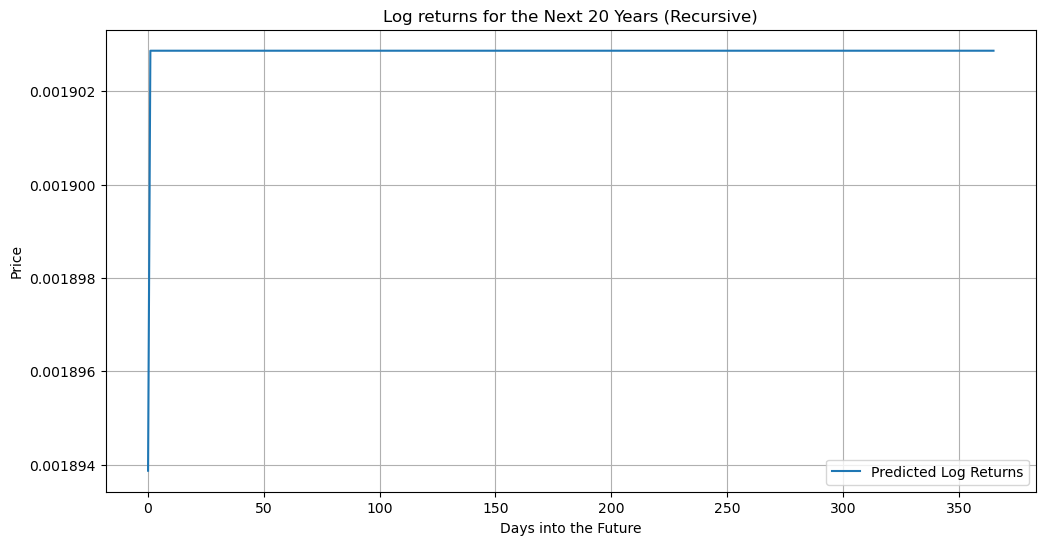

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(range(future_days + 1), future_log_returns, label="Predicted Log Returns")
plt.title("Log returns for the Next 20 Years (Recursive)")
plt.xlabel("Days into the Future")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

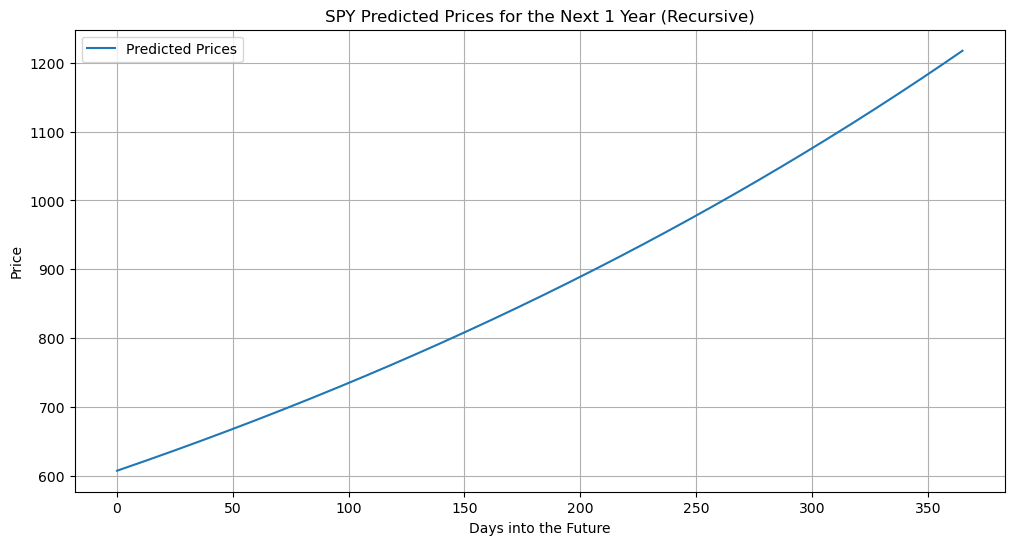

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(range(future_days + 1), predicted_prices, label="Predicted Prices")
plt.title("SPY Predicted Prices for the Next 1 Year (Recursive)")
plt.xlabel("Days into the Future")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [16]:
print(f"The price of SPY in 2044 will be {predicted_prices[-1]}")

The price of SPY in 2044 will be 1217.3432101353994
